# Supervised Learning With Decision Trees

In [1]:
import os
from PIL import Image, ImageFilter
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
alphabet_dir = "ASL_Dataset/Train"
max_images_per_folder = 1000
size = (256, 256)

Pre processing

In [3]:
def load_images_generator(folder_path, max_images_per_folder, size):
    image_counter = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            if image_counter >= max_images_per_folder:
                break
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.resize(size)
            image = image.convert('L')
            image = np.array(image) / 255.0
            image = remove_noise(image)
            yield image
            image_counter += 1

def remove_noise(image):
    pil_image = Image.fromarray(np.uint8(image*255))  
    denoised_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))
    denoised_array = np.array(denoised_image) / 255.0  
    return denoised_array

def load_images():
    images = []
    labels = []

    for folder_name in os.listdir(alphabet_dir):
        folder_path = os.path.join(alphabet_dir, folder_name)
        folder_images = load_images_generator(folder_path, max_images_per_folder, size)
        images.extend(folder_images)
        labels.extend([folder_name] * max_images_per_folder)

    return np.array(images), np.array(labels)

In [4]:
images, labels = load_images()
len(labels)

28000

In [5]:
random_indices = np.random.choice(len(labels), size=4, replace=False)

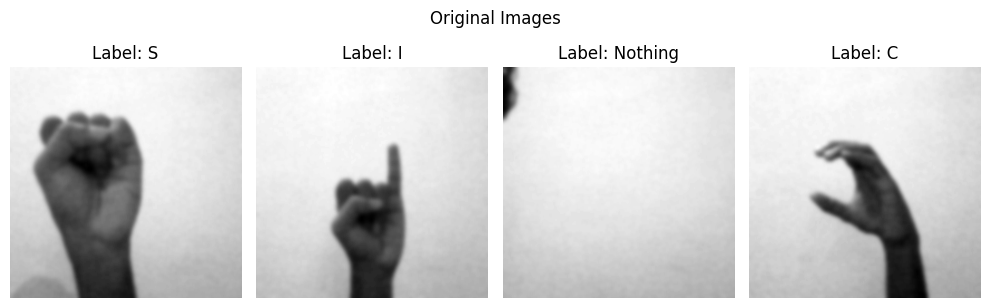

In [6]:
def visualize_original_images(images, labels):

    original_images = images[random_indices]
    original_labels = labels[random_indices]

    plt.figure(figsize=(10, 6))
    for i in range(4):
        plt.subplot(2, 4, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        plt.title(f"Label: {original_labels[i]}")
        plt.axis('off')
    plt.suptitle('Original Images')
    plt.tight_layout()
    plt.show()

visualize_original_images(images, labels)

PCA

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def preprocess_data(images, labels,num_components):
    flattened_images = images.reshape(images.shape[0], -1)
    scaler = StandardScaler()
    standardized_images = scaler.fit_transform(flattened_images)
    pca = PCA(n_components=num_components)
    reduced_images = pca.fit_transform(standardized_images)
    reconstructed_images = pca.inverse_transform(reduced_images)
    return reconstructed_images, reduced_images,labels

reconstructed_images,reduced_images,labels = preprocess_data(images, labels,25)

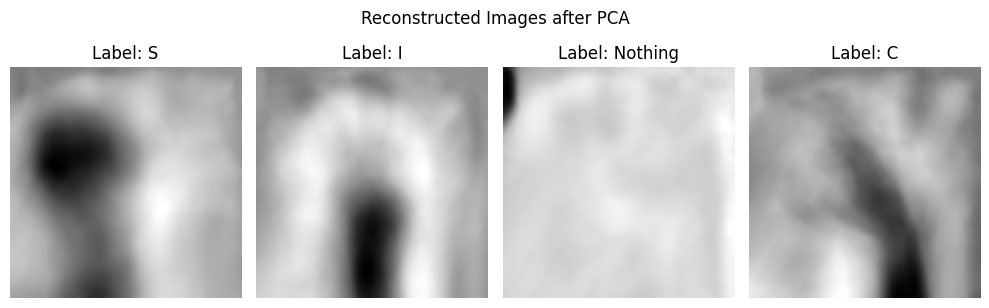

In [8]:
def visualize_reconstructed_images(reconstructed_images, labels):
    reconstructed_img = reconstructed_images[random_indices]
    reconstructed_labels = labels[random_indices]

    plt.figure(figsize=(10, 6))
    for i in range(4):
        plt.subplot(2, 4, i + 1)
        plt.imshow(reconstructed_img[i].reshape(size), cmap='gray')
        plt.title(f"Label: {reconstructed_labels[i]}")
        plt.axis('off')
    plt.suptitle('Reconstructed Images after PCA')
    plt.tight_layout()
    plt.show()

visualize_reconstructed_images(reconstructed_images, labels)

Outlier Detection

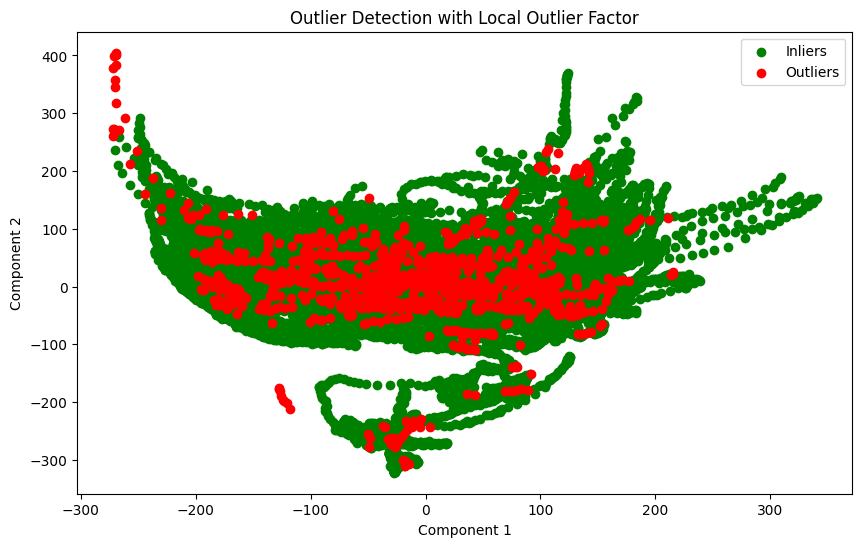

In [9]:
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import LocalOutlierFactor

def visualize_outlier_detection(reduced_images):
    # Perform outlier detection
    outlier_detector = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    outlier_labels = outlier_detector.fit_predict(reduced_images)

    outliers = reduced_images[outlier_labels == -1]
    inliers = reduced_images[outlier_labels == 1]

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(inliers[:, 0], inliers[:, 1], c='green', label='Inliers')
    plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers')
    plt.title('Outlier Detection with Local Outlier Factor')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()


visualize_outlier_detection(reduced_images)


In [10]:
import cupy as cp

In [11]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(images, y_encoded, test_size=0.2, stratify=y_encoded)


In [12]:

X_labeled_flat = X_labeled.reshape(X_labeled.shape[0], -1)
X_unlabeled_flat = X_unlabeled.reshape(X_unlabeled.shape[0], -1)

X_labeled_gpu = cp.asarray(X_labeled_flat)
y_labeled_gpu = cp.asarray(y_labeled)
X_unlabeled_gpu = cp.asarray(X_unlabeled_flat)
y_unlabeled_gpu = cp.asarray(y_unlabeled)

Class Distribution

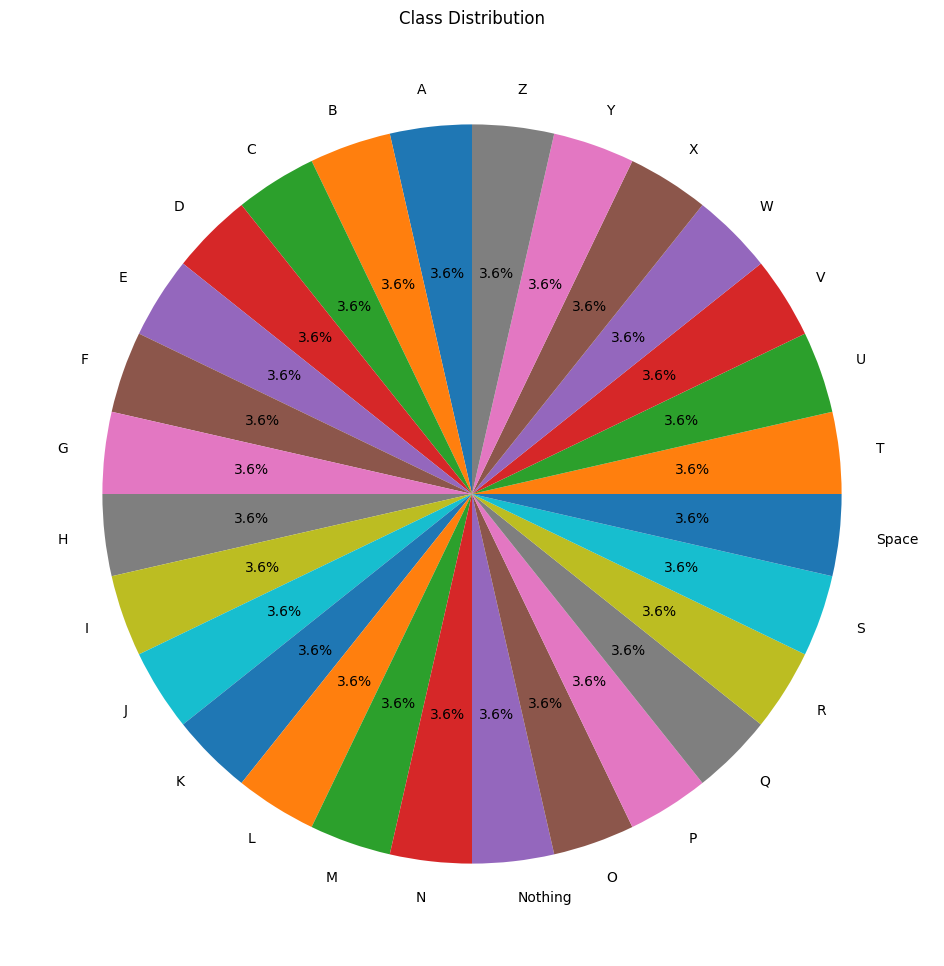

In [13]:

class_labels, class_counts = np.unique(y_labeled, return_counts=True)
class_names = label_encoder.classes_
plt.figure(figsize=(15, 12))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)

plt.title('Class Distribution')

plt.show()


Confusion Matrix, Decision Tree

In [14]:
def visualize_confusion_matrix(y_true, y_pred, label_encoder):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 9))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(label_encoder.classes_))
    plt.xticks(tick_marks, label_encoder.classes_, rotation=90)
    plt.yticks(tick_marks, label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(label_encoder.classes_)):
        for j in range(len(label_encoder.classes_)):
            plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center')

    plt.show()

In [15]:
def train_decision_tree(X_train, y_train):
    clf = DecisionTreeClassifier(random_state=2411)
    param_grid = {
        'max_depth': [8],
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 5, 10]
        
    }
    grid_search = GridSearchCV(clf, param_grid, cv=3)
    grid_search.fit(cp.asnumpy(X_train), cp.asnumpy(y_train))
    return grid_search,clf

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(cp.asnumpy(X_test))
    accuracy = accuracy_score(cp.asnumpy(y_test), cp.asnumpy(y_pred))
    report = classification_report(cp.asnumpy(y_test), cp.asnumpy(y_pred))
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("Classification Report:\n", report)
    visualize_confusion_matrix(cp.asnumpy(y_test), cp.asnumpy(y_pred), label_encoder)

In [16]:
model,clf = train_decision_tree(X_labeled_gpu, y_labeled_gpu)
print(model.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=5,
                       random_state=2411)


Accuracy, Precision , Recall , F1-score

Accuracy: 89.14%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85       120
           1       0.82      0.94      0.88       120
           2       0.80      0.92      0.86       120
           3       0.96      0.88      0.92       120
           4       0.83      0.69      0.75       120
           5       0.95      0.88      0.91       120
           6       0.92      0.93      0.92       120
           7       0.91      0.93      0.92       120
           8       0.87      0.82      0.85       120
           9       0.97      0.89      0.93       120
          10       0.79      0.95      0.86       120
          11       0.90      0.93      0.91       120
          12       0.88      0.83      0.85       120
          13       0.83      0.80      0.82       120
          14       1.00      1.00      1.00       120
          15       0.92      0.96      0.94       120
          16       0.95      0.93      0

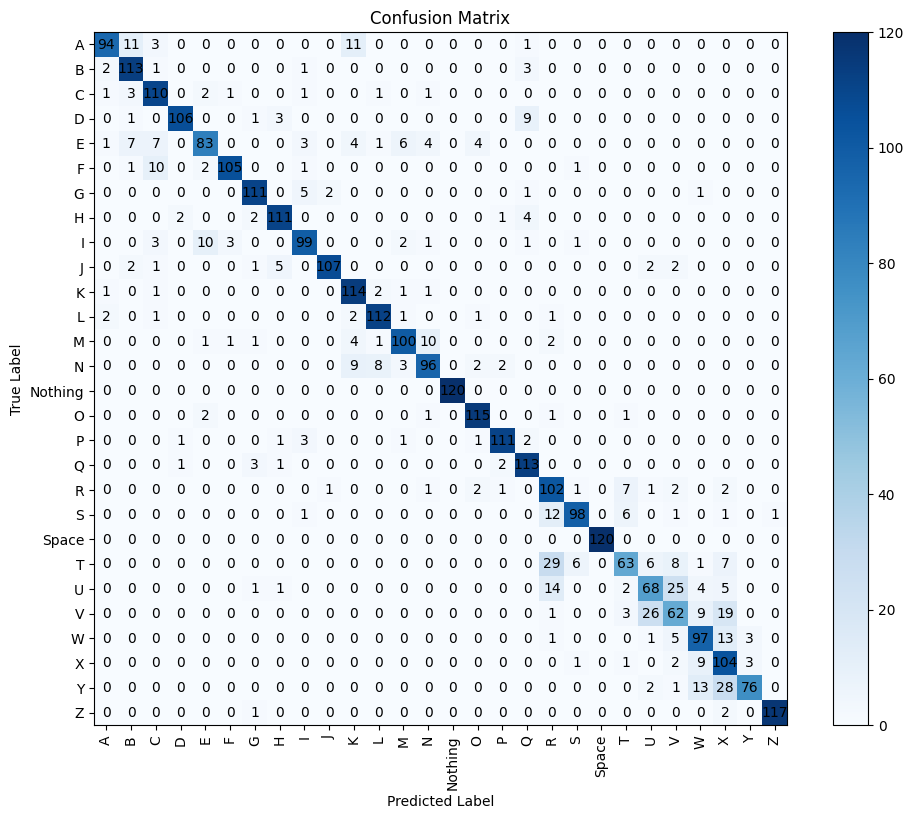

In [17]:
evaluate_model(model, X_unlabeled_gpu, y_unlabeled_gpu)

In [18]:
def visualize_tsne(X, y, label_encoder):
    X_embedded = TSNE(n_components=2).fit_transform(cp.asnumpy(X))
    plt.figure(figsize=(10, 8))
    for class_label in np.unique(cp.asnumpy(y)):
        indices = (cp.asnumpy(y) == class_label)
        plt.scatter(X_embedded[indices, 0], X_embedded[indices, 1], label=label_encoder.inverse_transform([class_label])[0])
    plt.title("t-SNE Visualization")
    plt.legend()
    plt.show()

In [19]:
def visualize_tree(model, feature_names, class_names):
    plt.figure(figsize=(12, 9))
    plot_tree(model, filled=True, feature_names=feature_names, class_names=class_names, max_depth=3)
    plt.show()

T-SNE plot

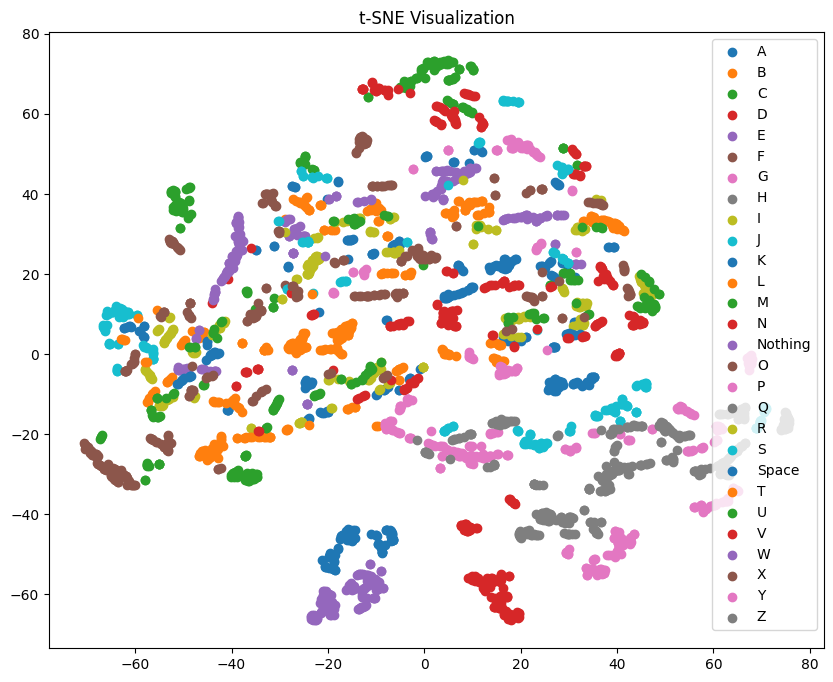

In [20]:
from sklearn.tree import plot_tree
X_unlabeled_flat = X_unlabeled.reshape(X_unlabeled.shape[0], -1)

X_unlabeled= cp.asarray(X_unlabeled_flat)

visualize_tsne(X_unlabeled, y_unlabeled, label_encoder)

feature_names = [str(i) for i in range(X_labeled_flat.shape[1])]
class_names = label_encoder.classes_


Decision Tree visualization

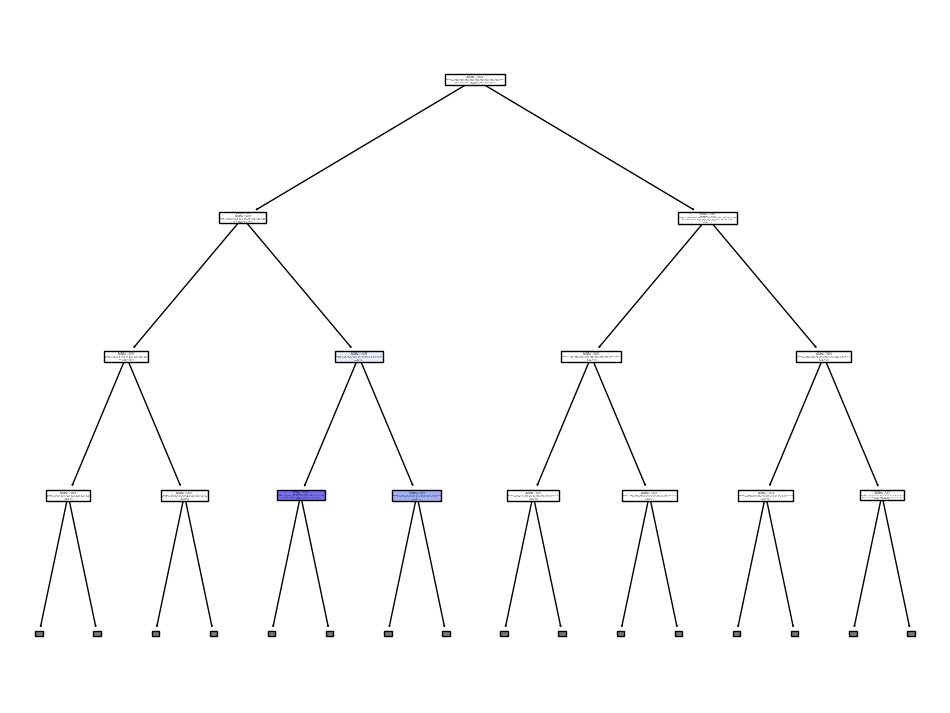

In [21]:
visualize_tree(model.best_estimator_, feature_names, class_names)